In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2024-11-10 14:50:36.820447: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 14:50:36.903500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731221436.938865   61414 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731221436.950332   61414 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 14:50:37.013947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Data

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(x_train_set, y_train_set), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
x_train_set = x_train_set / 255.0
x_test = x_test / 255.0

### (check data)

In [4]:
x_train_set.shape, y_train_set.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

2


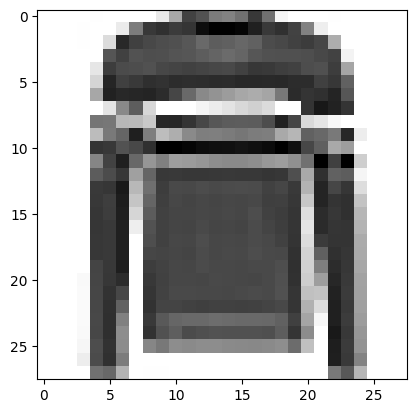

In [5]:
i = 5
print(y_train_set[i])
plt.imshow(x_train_set[i], cmap="binary")
plt.show()

### Split data

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_set, y_train_set, random_state=1
)

## Variational Autoencoder
### 1. Build model

In [7]:
class Sampling(keras.layers.Layer):  # keras沒有定義Sampling
    def call(self, inputs):
        # 會包含二部分：mean, log σ**2(CPU運算會較快)(轉成σ=exp(log σ**2/2))
        mean, log_var = inputs
        # ε 是從標準常態分配中抽出的，其個數必須和(log σ**2)一致
        e = tf.random.normal(tf.shape(log_var))
        # Z = μ + ε * exp(log  σ**2/2)
        return mean + e * tf.math.exp(log_var / 2)

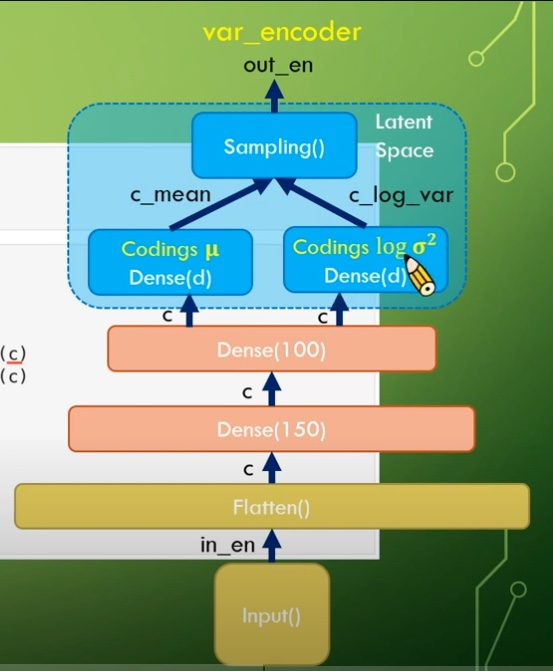

In [8]:
from IPython.display import Image

Image("img/5.3.1-01.jpeg", width=400)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(1)
np.random.seed(1)

In [9]:
d = 10  # 代表最后輸出時的數量

in_en = keras.layers.Input(shape=[28, 28])
# 因結構特殊，不能使用Sequential，改用Functional方式
c = keras.layers.Flatten()(in_en)  # (in_en)代表輸入層，要傳到Flatten層
c = keras.layers.Dense(150, activation="selu")(c)
c = keras.layers.Dense(100, activation="selu")(c)

c_mean = keras.layers.Dense(d)(c)
c_log_var = keras.layers.Dense(d)(c)

out_en = Sampling()([c_mean, c_log_var])

var_encoder = keras.models.Model(inputs=[in_en], outputs=[out_en])

I0000 00:00:1731221556.153888   61414 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [10]:
var_encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 784)       │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 150)       │    117,750 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     15,100 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 10)        │          0 │ dense_2[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 134,870 (526.84 KB)

 Trainable params: 134,870 (526.84 KB)

 Non-trainable params: 0 (0.00 B)

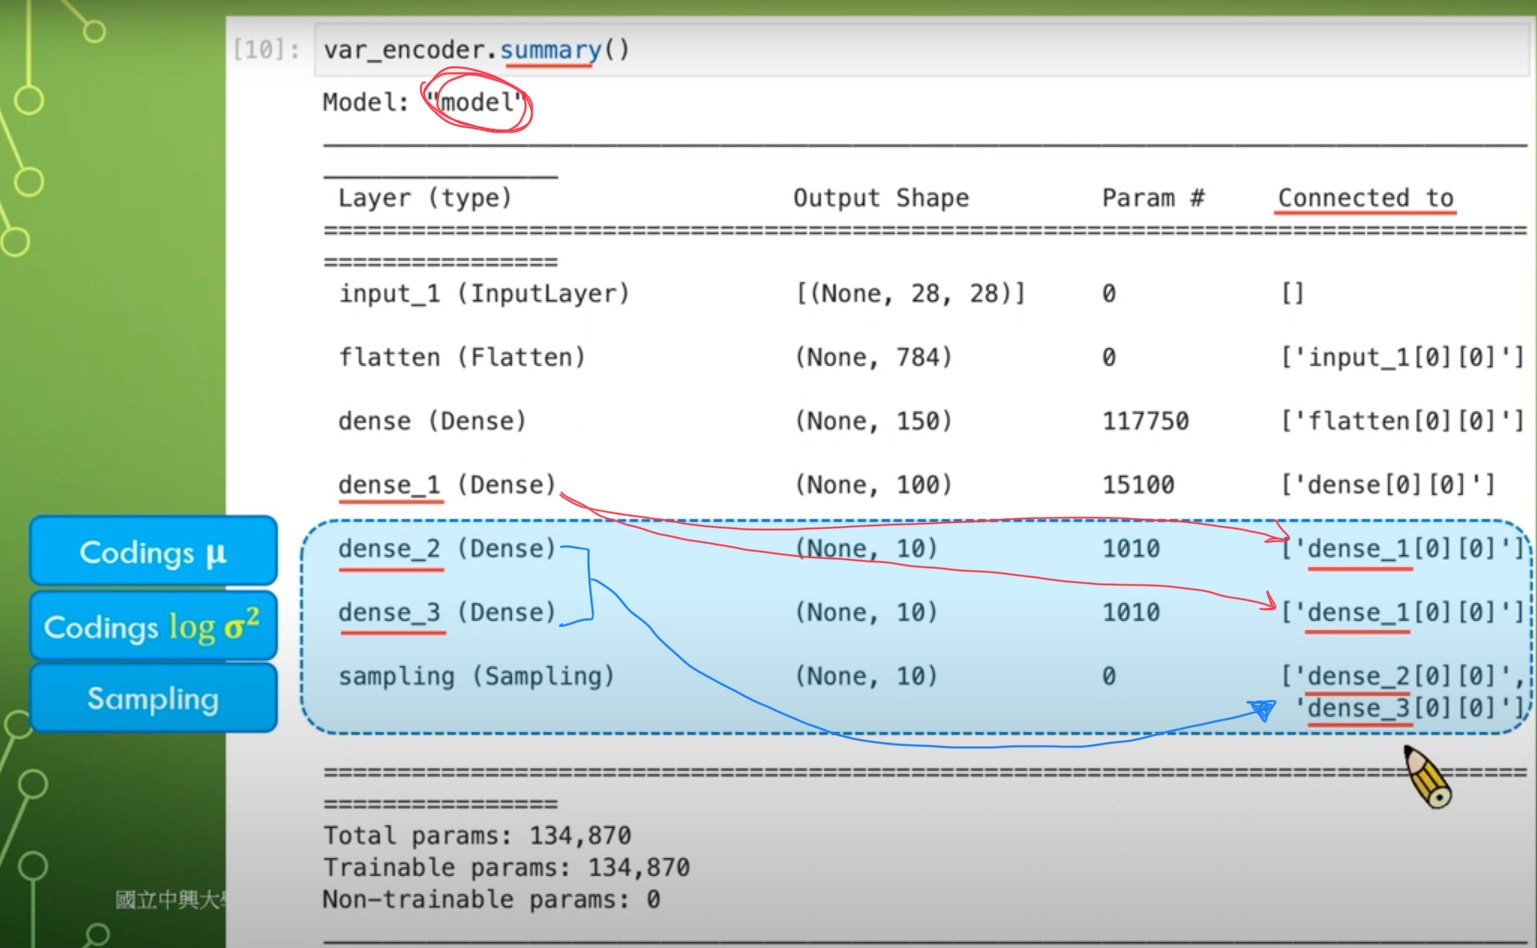

In [11]:
Image("img/5.3.1-02.jpeg", width=800)

In [12]:
in_de = keras.layers.Input(shape=[d])

x = keras.layers.Dense(100, activation="selu")(in_de)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)

out_de = keras.layers.Reshape([28, 28])(x)

var_decoder = keras.models.Model(inputs=[in_de], outputs=[out_de])

In [13]:
var_decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 150)            │        15,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 784)            │       118,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,634 (525.91 KB)

 Trainable params: 134,634 (525.91 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
codings = var_encoder(in_en)
rec = var_decoder(codings)

# (var_encoder + [codings) + var_decoder]
var_ae = keras.models.Model(inputs=[in_en], outputs=[rec])

In [15]:
var_ae.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 10)             │       134,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 28, 28)         │       134,634 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,504 (1.03 MB)

 Trainable params: 269,504 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

### 2. Compile

In [16]:
# 若樣本是30*20(Coding)，則公式括號裡的值代表每一樣本的Coding值，所以累加->得到30個值
D_KL = -0.5 * tf.math.reduce_sum(
    # 公式：∑(1+log σ**2 - σ**2 - μ**2) ; σ**2 = exp(log σ**2)
    1 + c_log_var - tf.math.exp(c_log_var) - tf.math.square(c_mean),
    axis=1,
)
# 所有累加值求平均
latent_loss = tf.math.reduce_mean(D_KL) / 784.0  # 784個神經元

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
var_ae.add_loss(latent_loss)

In [17]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))
    # 四捨五入，即 0或 1，若預測與真實相同，則得到 1分

In [18]:
var_ae.compile(
    loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy]
)

### 3. Train

In [19]:
train = var_ae.fit(
    x_train,
    x_train,  # 訓練完與原來的x_train進行比較
    epochs=20,
    batch_size=256,
    validation_data=(x_valid, x_valid),
)

Epoch 1/20


/home/chesterxalan/github/Classwork/Classwork-PythonDLApplicationDevelopment/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1731221705.471661   61851 service.cc:148] XLA service 0x7f49bc00d060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731221705.472826   61851 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-10 14:55:05.556464: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731221705.706379   61851 cuda_dnn.cc:529] Loaded cuDNN version 90300


 22/176 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6378 - rounded_accuracy: 0.6081

I0000 00:00:1731221706.815926   61851 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.4774 - rounded_accuracy: 0.7590 - val_loss: 0.3581 - val_rounded_accuracy: 0.8716
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3494 - rounded_accuracy: 0.8759 - val_loss: 0.3293 - val_rounded_accuracy: 0.8881
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3277 - rounded_accuracy: 0.8947 - val_loss: 0.3186 - val_rounded_accuracy: 0.9027
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3207 - rounded_accuracy: 0.9008 - val_loss: 0.3156 - val_rounded_accuracy: 0.9055
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3174 - rounded_accuracy: 0.9035 - val_loss: 0.3104 - val_rounded_accuracy: 0.9105
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3144 - rounded_accuracy: 0.9065 - val_loss: 0.3140 - val_rounded_accuracy: 0.9094
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3127 - rounded_accuracy: 0.9078 - val_loss: 0.3102 - val_rounded_accuracy: 0.9060
Ep

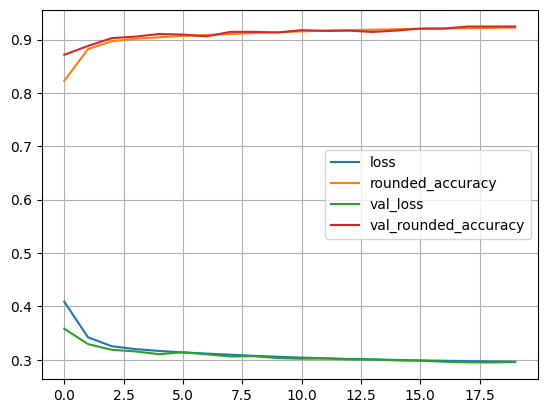

In [20]:
pd.DataFrame(train.history).plot()
plt.grid(True)
plt.show()


### 4. Evaluate

In [21]:
var_ae.evaluate(x_test, x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2986 - rounded_accuracy: 0.9239


[0.29891711473464966, 0.9232232570648193]

### 5. Predcit (Reconstruct)

In [22]:
x_test_decoded = var_ae.predict(x_test)

/home/chesterxalan/github/Classwork/Classwork-PythonDLApplicationDevelopment/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [23]:
x_test_decoded

[array([[[4.18689569e-06, 1.16227773e-06, 6.32009645e-08, ...,
          5.37835558e-06, 2.42272426e-06, 2.48021047e-06],
         [2.23795496e-06, 1.49383972e-08, 3.22673714e-07, ...,
          1.10278364e-07, 1.12934076e-05, 2.12237937e-05],
         [4.25041662e-06, 6.99102566e-06, 3.96427509e-07, ...,
          1.75838181e-06, 1.10576248e-05, 1.07239539e-05],
         ...,
         [2.38456560e-05, 9.00909708e-06, 4.81780660e-07, ...,
          1.11106033e-06, 1.06064790e-05, 1.81378418e-05],
         [1.59195006e-05, 1.22486642e-06, 2.19820393e-07, ...,
          2.65638931e-07, 1.08993947e-06, 6.10723600e-06],
         [2.19293452e-06, 1.44307558e-06, 2.51291885e-06, ...,
          8.88112197e-07, 2.09301402e-06, 7.12388214e-07]],
 
        [[4.56705902e-06, 8.21561298e-06, 4.40231361e-06, ...,
          1.66690243e-05, 9.30215901e-06, 1.36065646e-05],
         [1.11475492e-05, 5.87566547e-06, 2.02286283e-05, ...,
          1.26776547e-04, 7.64939177e-05, 4.88099386e-06],
       

TypeError: Invalid shape (10000, 28, 28) for image data

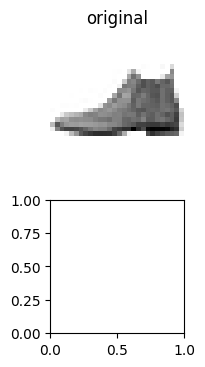

In [24]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, 1 + i)  # 編號 1開始
    plt.imshow(x_test[i], cmap="binary")
    plt.title("original")
    plt.axis("off")

    plt.subplot(2, 5, 1 + 5 + i)  # 編號 6開始
    plt.imshow(x_test_decoded[i], cmap="binary")
    plt.title("reconstructed")
    plt.axis("off")

plt.show()

## Generate Fashion Images產生圖片

In [25]:
tf.random.set_seed(1)

random_codings = tf.random.normal(shape=[5, d])  # 隨機產生5*10(Coding)
imgs = var_decoder(random_codings)

/home/chesterxalan/github/Classwork/Classwork-PythonDLApplicationDevelopment/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_7']. Received: the structure of inputs=*
  warnings.warn(


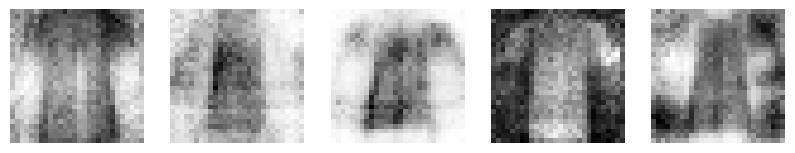

In [26]:
plt.figure(figsize=(10, 2))

for i in range(5):
    plt.subplot(1, 5, 1 + i)
    plt.imshow(imgs[i], cmap="binary")
    plt.axis("off")

plt.show()